### Necessary Packages

In [1]:
import sys
import os
import torch
import pandas as pd
sys.path.append('../..')
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
from src.utils import load, load_checkpoint, seed_everything, score
from src.training.cnn_k_fold import create_dataloaders,create_network,Config
from src.models import ResNet
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix,auc,roc_curve,roc_auc_score
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from definitions import *
from functools import reduce

### Global

In [2]:
EXPIREMENT_NAME = 'vit_tiny_2'
EXPIREMENT_PATH = os.path.join(EXPIREMENTS_DIR,EXPIREMENT_NAME)
CHECKPOINTS_PATH = os.path.join(EXPIREMENT_PATH,'checkpoints')
CONFIG_PATH = os.path.join(EXPIREMENT_PATH,'config.json')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load configurations

In [3]:
config = Config(**load(CONFIG_PATH))
loaders,test_loader = create_dataloaders(config)

### Reproducibility

In [4]:
seed_everything(config.seed)

### Models loading

In [5]:
def create_models(checkpoints_path : str):

    models = []
    files = sorted(os.listdir(CHECKPOINTS_PATH), key=lambda x: int(x.split('_')[-1].split('.')[0]))

    for i,checkpoint in enumerate(tqdm(files)):

        model = create_network(config)
        checkpoint = load_checkpoint(os.path.join(checkpoints_path, checkpoint), f'checkpoint_fold={i}.pt')
        model.load_state_dict(checkpoint['model'])
        model.to(DEVICE)
        model.eval()
        models.append(model)

    return models

In [6]:
models = create_models(CHECKPOINTS_PATH)

  0%|          | 0/5 [00:00<?, ?it/s]

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_tiny_patch16_224.augreg_in21k_ft_in1k)
INFO:timm.models._hub:[timm/vit_tiny_patch16_224.augreg_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_tiny_patch16_224.augreg_in21k_ft_in1k)
INFO:timm.models._hub:[timm/vit_tiny_patch16_224.augreg_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_tiny_patch16_224.augreg_in21k_ft_in1k)
INFO:timm.models._hub:[timm/vit_tiny_patch16_224.augreg_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (tim

In [7]:
### Save the models
for i,model in enumerate(models):
    torch.save(model.state_dict(),os.path.join(EXPIREMENT_PATH,f'model_fold={i}.pth'))

### Make predictions on individual folds

In [8]:
def predict(model: ResNet, dataloader: DataLoader):

    model.eval()

    y_true = []
    y_pred = []

    for x,y in tqdm(dataloader):

        x = x.to(DEVICE)
        y_hat = model.predict(x).detach().cpu().numpy()

        y_true.extend(y.numpy())
        y_pred.extend(y_hat)

    return y_true,y_pred

In [9]:
def predict_all(models: list, dataloaders: list[DataLoader] | DataLoader):
    
    results = {}

    for i,model in enumerate(models):

        if isinstance(dataloaders,list):
            dataloader = dataloaders[i]
        else:
            dataloader = dataloaders

        y_true,y_pred = predict(model,dataloader)

        results[f'fold_{i}'] = pd.DataFrame({
            'y_true': y_true,
            'y_pred': y_pred
        })

    return results

In [10]:
result = predict_all(models,list((val_loader for _,val_loader in loaders)))

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

In [11]:
result['fold_0'].head()

,y_true,y_pred
0,0.0,0.000128
1,0.0,0.000499
2,0.0,0.000327
3,0.0,0.000534
4,0.0,0.000086


### Calculate Fold-metrics

In [12]:
def calculate_metrics(y_true : np.ndarray,y_hard : np.ndarray,y_prob : np.ndarray) -> pd.Series:

    accuracy = accuracy_score(y_true,y_hard)
    f1 = f1_score(y_true,y_hard)
    precision = precision_score(y_true,y_hard)
    recall = recall_score(y_true,y_hard)
    roc_auc = roc_auc_score(y_true,y_prob)
    pauc = score(y_true,y_prob)

    results = {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'pauc': pauc
    }

    return pd.Series(results)

In [13]:
def calculate_all_metrics(result: dict[str,pd.DataFrame]) -> pd.DataFrame:

    metrics = []

    for fold in result.keys():

        y_true = result[fold]['y_true']
        y_pred = np.int32(result[fold]['y_pred'] > 0.5)
        y_prob = result[fold]['y_pred']

        fold_result = calculate_metrics(y_true,y_pred,y_prob)
        fold_result.name = fold

        metrics.append(fold_result)

    metrics = pd.DataFrame(metrics)

    means = metrics.mean(axis=0)
    stds = metrics.std(axis=0)
    metrics.loc['mean'] = means
    metrics.loc['std'] = stds

    return metrics

In [14]:
fold_metrics = calculate_all_metrics(result)

In [15]:
fold_metrics

,accuracy,f1,precision,recall,roc_auc,pauc
fold_0,0.979998,0.042949,0.022455,0.491803,0.948481,0.164679
fold_1,0.990575,0.094828,0.053140,0.440000,0.925691,0.139083
fold_2,0.979070,0.029146,0.015184,0.362069,0.910637,0.137152
fold_3,0.984516,0.065041,0.034951,0.467532,0.928075,0.145140
fold_4,0.984157,0.039891,0.021174,0.343750,0.883599,0.120285
mean,0.983663,0.054371,0.029381,0.421031,0.919297,0.141268
std,0.004563,0.026110,0.015103,0.065153,0.024078,0.016008


<Axes: ylabel='pauc'>

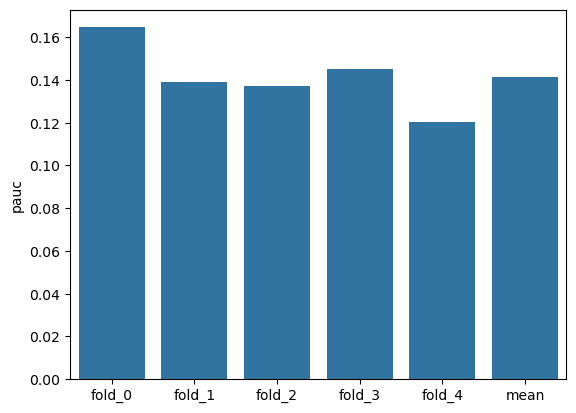

In [16]:
sns.barplot(fold_metrics['pauc'].drop('std'))

### Calculate test-set metrics

In [17]:
test_result = predict_all(models,test_loader)

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

  0%|          | 0/2089 [00:00<?, ?it/s]

In [18]:
test_result['fold_0'].head()

,y_true,y_pred
0,0.0,0.001020
1,0.0,0.000044
2,0.0,0.001269
3,0.0,0.000287
4,0.0,0.022335


In [19]:
test_metrics = calculate_all_metrics(test_result)

In [20]:
test_metrics

,accuracy,f1,precision,recall,roc_auc,pauc
fold_0,0.974014,0.030151,0.015580,0.465517,0.926197,0.150793
fold_1,0.991293,0.055195,0.030466,0.293103,0.926804,0.153013
fold_2,0.974762,0.026544,0.013731,0.396552,0.925800,0.151088
fold_3,0.984187,0.038217,0.020173,0.362069,0.903815,0.129513
fold_4,0.980073,0.030568,0.015957,0.362069,0.887814,0.129555
mean,0.980866,0.036135,0.019182,0.375862,0.914086,0.142793
std,0.007152,0.011472,0.006734,0.062641,0.017616,0.012133


<Axes: ylabel='pauc'>

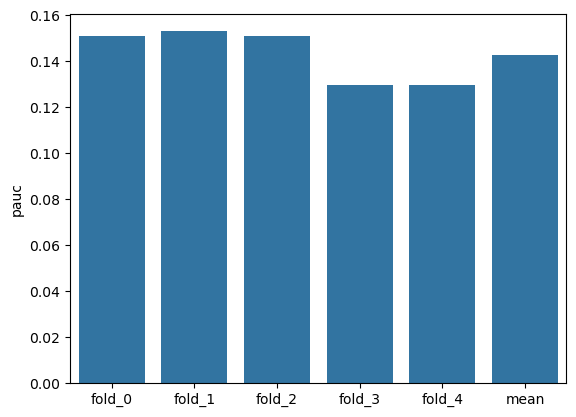

In [21]:
sns.barplot(test_metrics['pauc'].drop('std'))

### The mean of the models

In [22]:
mean = reduce(lambda a,b : a+b,(test_result[key]['y_pred'] for key in test_result.keys())) / len(test_result.keys())

In [23]:
mean_metrcis = calculate_metrics(test_result['fold_0']['y_true'],np.int32(mean > 0.5),mean)
mean_metrcis.name = 'mean'
mean_metrcis

accuracy     0.989647
f1           0.052055
precision    0.028274
recall       0.327586
roc_auc      0.940492
pauc         0.159634
Name: mean, dtype: float64